In [65]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Dataset and model path

In [66]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'

# Set number of classes

In [67]:
NUM_CLASSES = 9

# Dataset reading

In [68]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [69]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [71]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [72]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_6 (Dropout)         (None, 42)                0         
                                                                 
 dense_9 (Dense)             (None, 20)                860       
                                                                 
 dropout_7 (Dropout)         (None, 20)                0         
                                                                 
 dense_10 (Dense)            (None, 10)                210       
                                                                 
 dense_11 (Dense)            (None, 9)                 99        
                                                                 
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________


In [73]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [74]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [75]:
history = model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
 1/14 [=>............................] - ETA: 11s - loss: 2.4502 - accuracy: 0.0625
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
14/14 [==============================] - 2s 50ms/step - loss: 2.2748 - accuracy: 0.0936 - val_loss: 2.1945 - val_accuracy: 0.0752
Epoch 2/1000
 1/14 [=>............................] - ETA: 0s - loss: 2.2273 - accuracy: 0.1250
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
14/14 [==============================] - 0s 9ms/step - loss: 2.2060 - accuracy: 0.1278 - val_loss: 2.1722 - val_accuracy: 0.1538
Epoch 3/1000
 1/14 [=>............................] - ETA: 0s - loss: 2.2018 - accuracy: 0.1016
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
14/14 [==============================] - 0s 10ms/step - loss: 2.1903 - accuracy: 0.1386 - val_loss: 2.1633 - val_accuracy: 0.1573
Epoch 4/1000
 1/14 [=>............................] - ETA: 0s - loss: 2.1594 - accuracy: 0.156

In [76]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

5/5 [==============================] - 0s 3ms/step - loss: 0.5912 - accuracy: 0.9402


In [77]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [78]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 100ms/step
[0.2873886  0.00075297 0.09459176 0.504528   0.04697137 0.00203216
 0.0267882  0.00107508 0.03587188]
3


# Confusion matrix

19/19 [==============================] - 0s 2ms/step


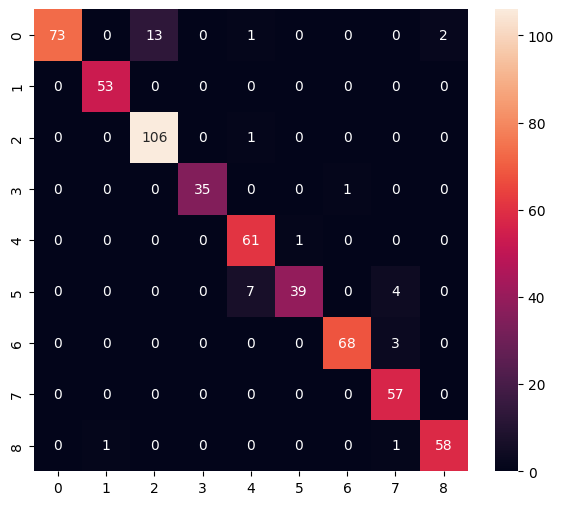

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.82      0.90        89
           1       0.98      1.00      0.99        53
           2       0.89      0.99      0.94       107
           3       1.00      0.97      0.99        36
           4       0.87      0.98      0.92        62
           5       0.97      0.78      0.87        50
           6       0.99      0.96      0.97        71
           7       0.88      1.00      0.93        57
           8       0.97      0.97      0.97        60

    accuracy                           0.94       585
   macro avg       0.95      0.94      0.94       585
weighted avg       0.95      0.94      0.94       585



In [79]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Loss Function Graph

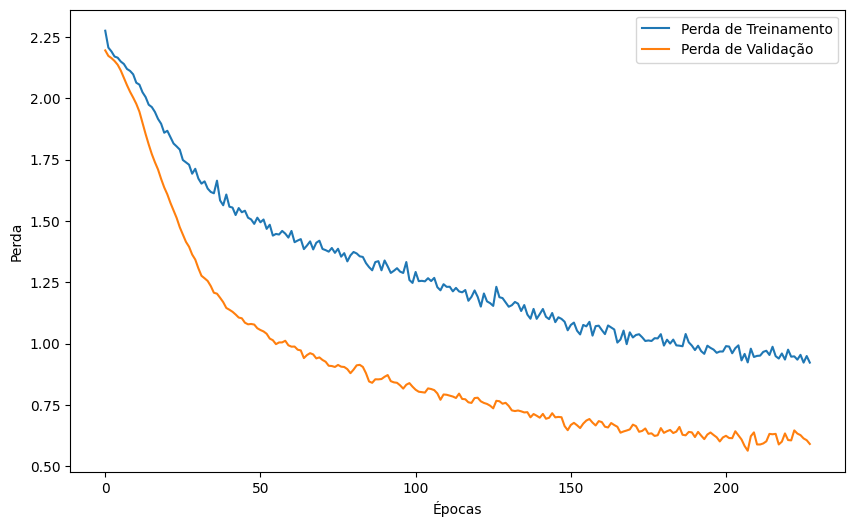

In [80]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Perda de Treinamento')
plt.plot(history.history['val_loss'], label='Perda de Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda')
# plt.title('Evolução da Função de Perda Durante o Treinamento')
plt.legend()
plt.show()

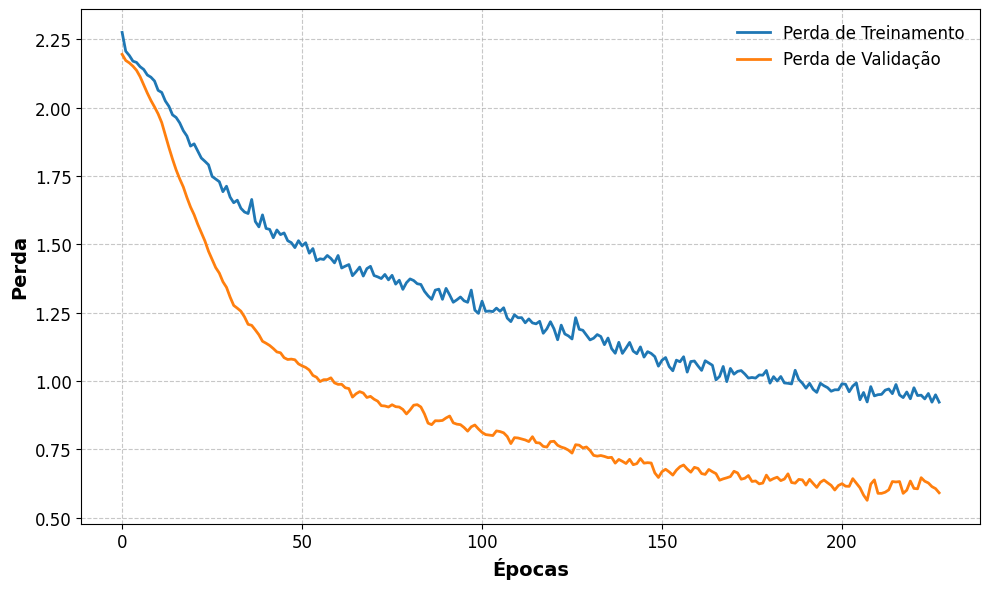

In [81]:
plt.figure(figsize=(10, 6))

plt.plot(history.history['loss'], label='Perda de Treinamento', linewidth=2)
plt.plot(history.history['val_loss'], label='Perda de Validação', linewidth=2)

plt.xlabel('Épocas', fontsize=14, fontweight='bold')
plt.ylabel('Perda', fontsize=14, fontweight='bold')
# plt.title('Evolução da Função de Perda Durante o Treinamento', fontsize=16, fontweight='bold')

plt.legend(fontsize=12, loc='upper right', frameon=False)
plt.grid(visible=True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

plt.show()

# Convert to model for Tensorflow-Lite

In [82]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [83]:
# Transform model (quantization)
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

2025-01-09 00:07:09.923080: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'input_4' with dtype float and shape [?,42]
	 [[{{node input_4}}]]
2025-01-09 00:07:10.023349: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,42]
	 [[{{node inputs}}]]
2025-01-09 00:07:10.047640: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'input_4' with dtype float and shape [?,42]
	 [[{{node input_4}}]]
2025-01-09 00:0

INFO:tensorflow:Assets written to: /tmp/tmp2e1rvq5e/assets


INFO:tensorflow:Assets written to: /tmp/tmp2e1rvq5e/assets
2025-01-09 00:07:12.124009: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2025-01-09 00:07:12.124113: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-01-09 00:07:12.124835: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp2e1rvq5e
2025-01-09 00:07:12.129898: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2025-01-09 00:07:12.129956: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp2e1rvq5e
2025-01-09 00:07:12.148181: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2025-01-09 00:07:12.498764: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: /tmp/tmp2e1rvq5e
2025-01-09 00:07:12.546315: I tensorflow/cc/saved_model/loader.cc:314] SavedModel

6816

# Inference test

In [84]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [85]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [86]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [87]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 114 μs, sys: 7 μs, total: 121 μs
Wall time: 2.85 ms


In [88]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[0.2873886  0.00075297 0.09459171 0.504528   0.04697143 0.00203216
 0.02678823 0.00107508 0.03587186]
3
